In [1]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema, NanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import hist.dask as dhist
import dask
import pickle
import os
import dask_awkward as dak
from coffea.lookup_tools.lookup_base import lookup_base

In [17]:
import coffea
coffea.__version__
fastjet.__version__

'3.5.1.1.dev2+gee024ac.d20250715'

In [9]:
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")

In [15]:
path = '/cms/cephfs/data/store/user/cmoore24/samples/2017/hbb/'
files = os.listdir(f'{path}')

events = NanoEventsFactory.from_root(
    {f'{path}' + files[0]: "/Events"},
    mode='dask',
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "hgg"},
).events()

In [16]:
fatjet = events.FatJet
cut = (fatjet.pt > 50)
slimmed = ak.mask(fatjet, cut)
pf = ak.flatten(slimmed.constituents.pf, axis=1)
jetdef = fastjet.JetDefinition(fastjet.cambridge_algorithm, 0.2)
cluster = fastjet.ClusterSequence(pf, jetdef)

In [11]:
pf = ak.flatten(hgg.FatJet.constituents.pf, axis=1)

In [12]:
jetdef = fastjet.JetDefinition(fastjet.cambridge_algorithm, 0.8)

In [13]:
cluster = fastjet.ClusterSequence(pf, jetdef)

In [14]:
softdrop = cluster.exclusive_jets_softdrop_grooming()
softdrop_cluster = fastjet.ClusterSequence(softdrop.constituents, jetdef)

In [18]:
a = softdrop.compute()

In [26]:
a.constituents.fields

['px', 'py', 'pz', 'E']

In [28]:
a.constituents[0]

<Array [{px: -209, py: 133, pz: ..., ...}, ...] type='2 * {px: float64, py:...'>

In [31]:
a.ptsoftdrop

<Array [303, 432, 395, 342, 407, ..., 303, 248, 407, 252] type='6795 * float64'>

In [37]:
import matplotlib.pyplot as plt

In [38]:
cms_n2 = hgg_fatjet.n2b1.compute()
base_n2 = cluster.exclusive_jets_energy_correlator(func="N2").compute()
sd_n2 = softdrop_cluster.exclusive_jets_energy_correlator(func="N2").compute()

In [39]:
cms_n3 = hgg_fatjet.n3b1.compute()
base_n3 = cluster.exclusive_jets_energy_correlator(func="N3").compute()
sd_n3 = softdrop_cluster.exclusive_jets_energy_correlator(func="N3").compute()

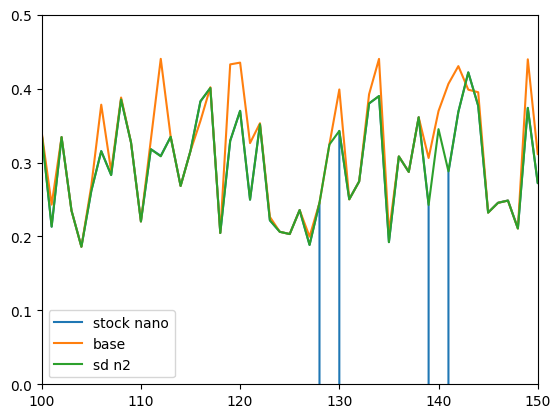

In [45]:
fig, ax = plt.subplots()
ax.plot(ak.flatten(cms_n2), label='stock nano')
ax.plot(base_n2, label='base')
ax.plot(sd_n2, label='sd n2')
ax.set_xlim(100,150)
ax.set_ylim(0,0.5)
plt.legend()
plt.show()

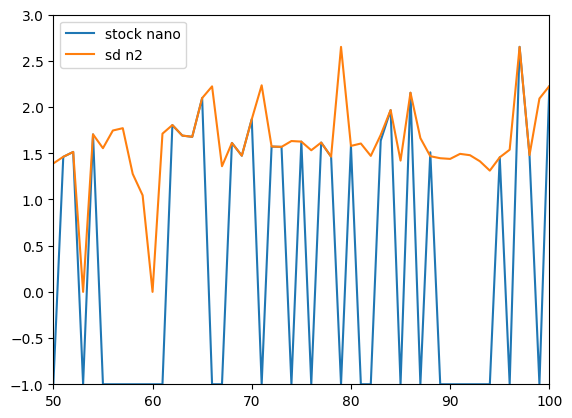

In [46]:
fig, ax = plt.subplots()
ax.plot(ak.flatten(cms_n3), label='stock nano')
#ax.plot(base_n3, label='base')
ax.plot(sd_n3, label='sd n2')
ax.set_xlim(50,100)
ax.set_ylim(-1,3)
plt.legend()
plt.show()

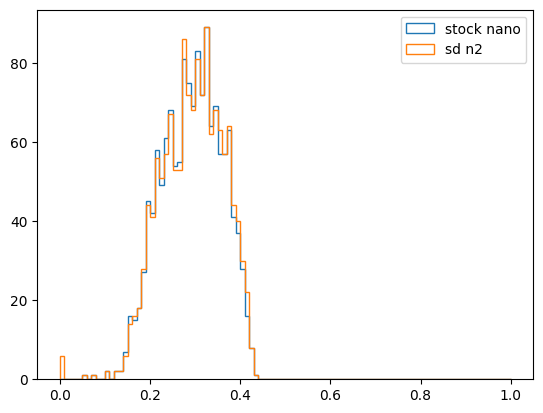

In [40]:
fig, ax = plt.subplots()
ax.hist(ak.flatten(cms_n2), label='stock nano', bins=100, range=(0,1), histtype='step')
#ax.hist(base_n2, label='base', bins=100, range=(0,1), histtype='step')
ax.hist(sd_n2, label='sd n2', bins=100, range=(0,1), histtype='step')
plt.legend()
plt.show()

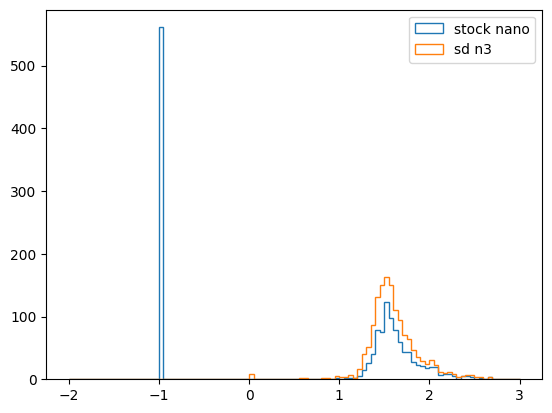

In [44]:
fig, ax = plt.subplots()
ax.hist(ak.flatten(cms_n3), label='stock nano', bins=100, range=(-2,3), histtype='step')
#ax.hist(base_n2, label='base', bins=100, range=(0,1), histtype='step')
ax.hist(sd_n3, label='sd n3', bins=100, range=(-2,3), histtype='step')
plt.legend()
plt.show()

In [17]:
cms_msd = hgg_fatjet.msoftdrop.compute()
fj_msoftdrop = softdrop.msoftdrop.compute()

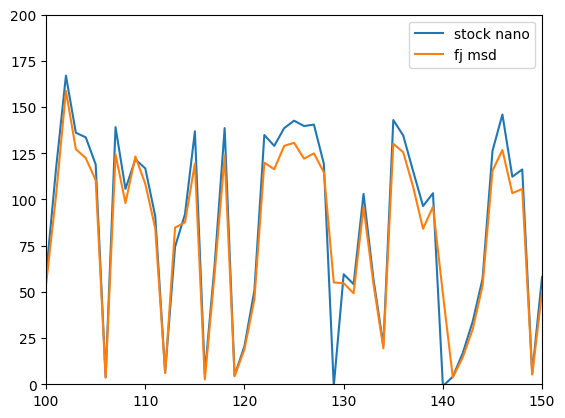

In [47]:
fig, ax = plt.subplots()
ax.plot(ak.flatten(cms_msd), label='stock nano')
ax.plot(fj_msoftdrop, label='fj msd')
ax.set_xlim(100,150)
ax.set_ylim(0,200)
plt.legend()
plt.show()

In [48]:
cms_pt = hgg_fatjet.pt.compute()
fj_pt = softdrop.ptsoftdrop.compute()

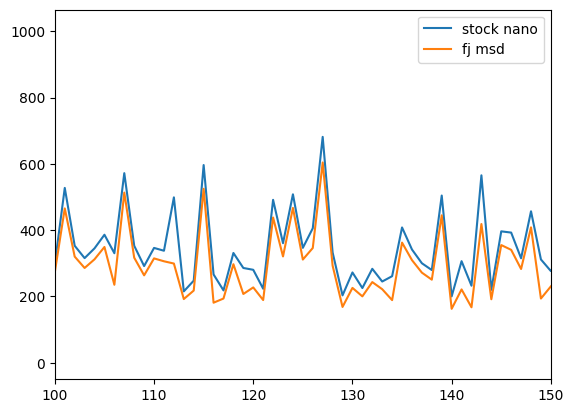

In [49]:
fig, ax = plt.subplots()
ax.plot(ak.flatten(cms_pt), label='stock nano')
ax.plot(fj_pt, label='fj msd')
ax.set_xlim(100,150)
#ax.set_ylim(0,200)
plt.legend()
plt.show()

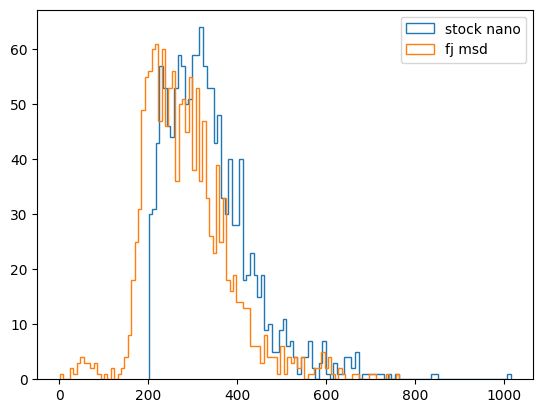

In [50]:
fig, ax = plt.subplots()
ax.hist(ak.flatten(cms_pt), label='stock nano', bins=100, histtype='step')
ax.hist(fj_pt, label='fj msd', bins=100, histtype='step')
#ax.set_xlim(100,150)
#ax.set_ylim(0,200)
plt.legend()
plt.show()

In [29]:
hgg_fatjet.constituents.pf.fields

['d0',
 'd0Err',
 'dz',
 'dzErr',
 'eta',
 'mass',
 'phi',
 'pt',
 'puppiWeight',
 'puppiWeightNoLep',
 'trkChi2',
 'vtxChi2',
 'charge',
 'lostInnerHits',
 'pdgId',
 'pvAssocQuality',
 'trkQuality']

In [74]:
class SoftDropWeight(lookup_base):
    def _evaluate(self, pt, eta):
        gpar = np.array([1.00626, -1.06161, 0.0799900, 1.20454])
        cpar = np.array([1.09302, -0.000150068, 3.44866e-07, -2.68100e-10, 8.67440e-14, -1.00114e-17])
        fpar = np.array([1.27212, -0.000571640, 8.37289e-07, -5.20433e-10, 1.45375e-13, -1.50389e-17])
        genw = gpar[0] + gpar[1]*np.power(pt*gpar[2], -gpar[3])
        cenweight = np.polyval(cpar[::-1], pt)
        forweight = np.polyval(fpar[::-1], pt)
        weight = np.where(np.abs(eta) < 1.3, cenweight, forweight)
        return genw*weight

In [75]:
_softdrop_weight = SoftDropWeight()

In [76]:
def corrected_msoftdrop(fatjets):
    sf = _softdrop_weight(fatjets.pt, fatjets.eta)
    sf = np.maximum(1e-5, sf)
    dazsle_msd = (fatjets.subjets * (1 - fatjets.subjets.rawFactor)).sum()
    return dazsle_msd.mass * sf

In [77]:
hgg_fatjet = hgg_fatjet.compute()

In [145]:
pt = ak.firsts(hgg.FatJet.pt)
eta = ak.firsts(hgg.FatJet.eta)
gpar = np.array([1.00626, -1.06161, 0.0799900, 1.20454])
cpar = np.array([1.09302, -0.000150068, 3.44866e-07, -2.68100e-10, 8.67440e-14, -1.00114e-17])
fpar = np.array([1.27212, -0.000571640, 8.37289e-07, -5.20433e-10, 1.45375e-13, -1.50389e-17])
genw = gpar[0] + gpar[1]*np.power(pt*gpar[2], -gpar[3])
cenweight = np.polyval(cpar[::-1], pt)
forweight = np.polyval(fpar[::-1], pt)
weight = np.where(np.abs(eta) < 1.3, cenweight, forweight)
sf = genw*weight
sf = np.maximum(1e-5, sf)
dazsle_msd = (hgg.SubJet * (1 - hgg.SubJet.rawFactor)).sum()

In [150]:
#ak.unflatten((ak.flatten(hgg.SubJet) * (1 - ak.flatten(hgg.SubJet.rawFactor))), counts=ak.num(hgg.SubJet)).sum()
fj_msoftdrop

<Array [70, 19.5, 105, 91.4, ..., 125, 2.16, 104, 45.2] type='1448 * float64'>

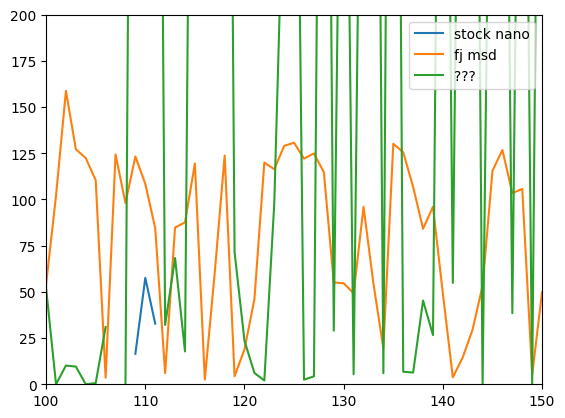

In [147]:
fig, ax = plt.subplots()
ax.plot(ak.firsts(cms_msd), label='stock nano')
ax.plot(fj_msoftdrop, label='fj msd')
ax.plot(check, label='???')
ax.set_xlim(100,150)
ax.set_ylim(0,200)
plt.legend()
plt.show()

In [78]:
files = os.listdir('/project01/ndcms/cmoore24/samples/qcd/3200toInf')

qcd = NanoEventsFactory.from_root(
    {'/project01/ndcms/cmoore24/samples/qcd/3200toInf/' + files[0]: "/Events"},
    #delayed=False,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "hbb"},
).events()

In [89]:
qcd = qcd.compute()
hgg = hgg.compute()

In [120]:
#hgg_exclusive = cluster.exclusive_jets(n_jets=3).compute()

In [ ]:
ak.all(ak.num(hgg_exclusive) == 3)

In [ ]:
cut = (
    (qcd.FatJet.pt > 200)
    & (qcd.FatJet.pt < 2500)
    & (qcd.FatJet.mass > 50)
    & (qcd.FatJet.mass < 200)
    & (abs(qcd.FatJet.eta) < 2.5) 
)

In [15]:
fatjet = qcd.FatJet[cut]

In [16]:
pf = ak.flatten(fatjet.constituents.pf, axis=1)

In [17]:
jetdef = fastjet.JetDefinition(fastjet.cambridge_algorithm, 0.2)

In [18]:
cluster = fastjet.ClusterSequence(pf, jetdef)

In [19]:
qcd_exclusive = cluster.exclusive_jets(n_jets=3).compute()

In [20]:
ak.all(ak.num(qcd_exclusive) == 3)

True

In [21]:
def color_ring(fatjet, cluster_val):
    pf = ak.flatten(fatjet.constituents.pf, axis=1)
    jetdef = fastjet.JetDefinition(fastjet.cambridge_algorithm, cluster_val)
    cluster = fastjet.ClusterSequence(pf, jetdef)
    subjets = cluster.exclusive_jets(n_jets=3)
    vec = ak.zip(
        {
            "x": subjets.px,
            "y": subjets.py,
            "z": subjets.pz,
            "t": subjets.E,
        },
        with_name="LorentzVector",
        behavior=vector.behavior,
    )
    vec = ak.pad_none(vec, 3)
    vec["norm3"] = np.sqrt(vec.dot(vec))
    vec["idx"] = ak.local_index(vec)
    i, j, k = ak.unzip(ak.combinations(vec, 3))
    #best = ak.argmin(abs((i + j + k).mass - 125), axis=1, keepdims=True)
    best = ak.argmax(abs((i + j + k).mass), axis=1, keepdims=True)
    order_check = ak.concatenate([i[best].mass, j[best].mass, k[best].mass], axis=1)
    largest = ak.argmax(order_check, axis=1, keepdims=True)
    smallest = ak.argmin(order_check, axis=1, keepdims=True)
    leading_particles = ak.concatenate([i[best], j[best], k[best]], axis=1)
    leg1 = leading_particles[largest]
    leg3 = leading_particles[smallest]
    leg2 = leading_particles[
        (leading_particles.idx != ak.flatten(leg1.idx))
        & (leading_particles.idx != ak.flatten(leg3.idx))
    ]
    leg1 = ak.firsts(leg1)
    leg2 = ak.firsts(leg2)
    leg3 = ak.firsts(leg3)
    a12 = np.arccos(leg1.dot(leg2) / (leg1.norm3 * leg2.norm3))
    a13 = np.arccos(leg1.dot(leg3) / (leg1.norm3 * leg3.norm3))
    a23 = np.arccos(leg2.dot(leg3) / (leg2.norm3 * leg3.norm3))
    color_ring = (a13**2 + a23**2) / (a12**2)
    return color_ring

In [22]:
uf_cr = ak.unflatten(
     color_ring(hgg_fatjet, cluster_val=0.2), counts=ak.num(hgg_fatjet)
).compute()

In [23]:
uf_cr

<Array [[2.28], [], [31.9], ..., [], [1.25], []] type='3000 * var * ?float64'>

In [24]:
subjets = qcd_exclusive

In [25]:
vec = ak.zip(
    {
        "x": subjets.px,
        "y": subjets.py,
        "z": subjets.pz,
        "t": subjets.E,
    },
    with_name="LorentzVector",
    behavior=vector.behavior,
)

In [26]:
vec = ak.pad_none(vec, 3)

In [27]:
vec["norm3"] = np.sqrt(vec.dot(vec))

In [28]:
vec["idx"] = ak.local_index(vec)

In [29]:
i, j, k = ak.unzip(ak.combinations(vec, 3))

In [30]:
best = ak.argmax(abs((i + j + k).mass), axis=1, keepdims=True)

In [31]:
order_check = ak.concatenate([i[best].mass, j[best].mass, k[best].mass], axis=1)

In [32]:
largest = ak.argmax(order_check, axis=1, keepdims=True)

In [33]:
smallest = ak.argmin(order_check, axis=1, keepdims=True)

In [34]:
leading_particles = ak.concatenate([i[best], j[best], k[best]], axis=1)

In [35]:
leg1 = leading_particles[largest]

In [36]:
leg3 = leading_particles[smallest]

In [37]:
leg2 = leading_particles[
    (leading_particles.idx != ak.flatten(leg1.idx))
    & (leading_particles.idx != ak.flatten(leg3.idx))
]

In [38]:
leg1 = ak.firsts(leg1)
leg2 = ak.firsts(leg2)
leg3 = ak.firsts(leg3)

In [39]:
a12 = leg1.delta_r2(leg2)

In [40]:
a13 = leg1.delta_r2(leg3)

In [41]:
a23 = leg2.delta_r2(leg3)

In [42]:
color_ring = (a13 + a23) / (a12)

In [46]:
leg1.eta

<Array [1.09, -0.491, -1.91, ..., -1.05, -1.98, -1.57] type='29369 * ?float64'>

In [73]:
i=4
leg1.pt[i]

2.8514720276930046

In [74]:
leg2.pt[i]

2.4940191514786236

In [75]:
leg3.pt[i]

3.584603171977805